In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import resample, shuffle

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False
})
import seaborn as sns

## Loading the dataset, pre-processing, and analysing the data

In [17]:
cohort_data = pd.read_csv('cohort_data.csv')
cohort_data

,subject_id,hadm_id,icustay_id,gender,age,icu_los_hours,min_wbc,max_wbc,mean_wbc,std_wbc,...,max_po2,mean_po2,std_po2,last_po2,min_pco2,max_pco2,mean_pco2,std_pco2,last_pco2,target
0,28162,194362,285686,F,18,49.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,22190,166880,290052,F,18,117.0,0.0,0.0,0.0,NaN,...,221.0,213.333333,6.806859,208.0,37.0,42.0,38.666667,2.886751,37.0,0
2,7717,159770,260370,F,18,34.0,9.0,9.0,9.0,NaN,...,274.0,216.000000,82.024387,158.0,40.0,40.0,40.000000,0.000000,40.0,0
3,69145,128969,213687,F,19,82.0,NaN,NaN,NaN,NaN,...,112.0,100.666667,11.503623,101.0,16.0,20.0,18.000000,2.000000,20.0,0
4,68035,145990,288524,F,19,22.0,NaN,NaN,NaN,NaN,...,58.0,58.000000,NaN,58.0,37.0,37.0,37.000000,NaN,37.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,26644,170124,296631,M,89,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
29279,21296,172695,266878,M,89,18.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
29280,27515,123997,232528,M,89,93.0,NaN,NaN,NaN,NaN,...,229.0,195.000000,35.618347,219.0,26.0,39.0,30.750000,5.737305,26.0,1
29281,23531,193022,234645,M,89,234.0,NaN,NaN,NaN,NaN,...,100.0,100.000000,NaN,100.0,43.0,43.0,43.000000,NaN,43.0,0


In [18]:
# Data available in most of the patients:
df = cohort_data.dropna(subset=['icu_los_hours', 'min_hemoglobin', 'min_hematocrit', 'min_platelet count', 'min_sodium', 'min_potassium', 'min_chloride', 'min_bicarbonate', 'min_glucose', 'min_creatinine', 'min_urea nitrogen', 'min_ph', 'min_po2', 'min_pco2', 'target'])

# Drop sparse columns (missing values for many ICU entries)
df = df.dropna(axis=1, how='any')
df

,subject_id,hadm_id,icustay_id,gender,age,icu_los_hours,min_hemoglobin,max_hemoglobin,mean_hemoglobin,last_hemoglobin,...,last_ph,min_po2,max_po2,mean_po2,last_po2,min_pco2,max_pco2,mean_pco2,last_pco2,target
1,22190,166880,290052,F,18,117.0,9.4,11.9,10.266667,9.5,...,7.44,208.0,221.0,213.333333,208.0,37.0,42.0,38.666667,37.0,0
2,7717,159770,260370,F,18,34.0,11.6,12.4,12.000000,11.6,...,5.00,158.0,274.0,216.000000,158.0,40.0,40.0,40.000000,40.0,0
3,69145,128969,213687,F,19,82.0,10.8,10.9,10.850000,10.8,...,7.55,89.0,112.0,100.666667,101.0,16.0,20.0,18.000000,20.0,0
5,42842,162017,267868,F,20,403.0,4.6,10.8,8.522222,4.6,...,7.23,42.0,188.0,89.125000,188.0,20.0,50.0,36.375000,37.0,0
6,88518,158955,224060,F,20,15.0,12.1,12.1,12.100000,12.1,...,7.26,43.0,43.0,43.000000,43.0,43.0,43.0,43.000000,43.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29268,26701,189710,242094,M,77,310.0,11.9,12.1,12.000000,12.1,...,8.00,127.0,162.0,144.500000,127.0,43.0,47.0,45.000000,43.0,0
29275,19609,155814,274163,M,84,27.0,11.5,11.5,11.500000,11.5,...,8.00,82.0,82.0,82.000000,82.0,62.0,62.0,62.000000,62.0,0
29277,28848,137939,219453,M,88,277.0,12.1,12.1,12.100000,12.1,...,7.47,89.0,106.0,97.500000,106.0,37.0,39.0,38.000000,39.0,0
29280,27515,123997,232528,M,89,93.0,12.9,12.9,12.900000,12.9,...,7.35,152.0,229.0,195.000000,219.0,26.0,39.0,30.750000,26.0,1


Summary of the filtered data

In [19]:
print(df.info())        # Data types and non-null counts
print(df.describe())    # Summary stats for numeric columns
print(df.describe(include='object')) 

<class 'pandas.core.frame.DataFrame'>
Index: 14899 entries, 1 to 29281
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           14899 non-null  int64  
 1   hadm_id              14899 non-null  int64  
 2   icustay_id           14899 non-null  int64  
 3   gender               14899 non-null  object 
 4   age                  14899 non-null  int64  
 5   icu_los_hours        14899 non-null  float64
 6   min_hemoglobin       14899 non-null  float64
 7   max_hemoglobin       14899 non-null  float64
 8   mean_hemoglobin      14899 non-null  float64
 9   last_hemoglobin      14899 non-null  float64
 10  min_hematocrit       14899 non-null  float64
 11  max_hematocrit       14899 non-null  float64
 12  mean_hematocrit      14899 non-null  float64
 13  last_hematocrit      14899 non-null  float64
 14  min_platelet count   14899 non-null  float64
 15  max_platelet count   14899 non-null  floa

In [20]:
df = df.drop('subject_id', axis=1)
df = df.drop('hadm_id', axis=1)
df = df.drop('icustay_id', axis=1)
df = df.drop('gender', axis=1)
df

,age,icu_los_hours,min_hemoglobin,max_hemoglobin,mean_hemoglobin,last_hemoglobin,min_hematocrit,max_hematocrit,mean_hematocrit,last_hematocrit,...,last_ph,min_po2,max_po2,mean_po2,last_po2,min_pco2,max_pco2,mean_pco2,last_pco2,target
1,18,117.0,9.4,11.9,10.266667,9.5,26.1,26.6,26.350000,26.1,...,7.44,208.0,221.0,213.333333,208.0,37.0,42.0,38.666667,37.0,0
2,18,34.0,11.6,12.4,12.000000,11.6,31.5,34.9,33.500000,34.1,...,5.00,158.0,274.0,216.000000,158.0,40.0,40.0,40.000000,40.0,0
3,19,82.0,10.8,10.9,10.850000,10.8,30.4,31.7,31.050000,30.4,...,7.55,89.0,112.0,100.666667,101.0,16.0,20.0,18.000000,20.0,0
5,20,403.0,4.6,10.8,8.522222,4.6,13.8,32.2,26.133333,13.8,...,7.23,42.0,188.0,89.125000,188.0,20.0,50.0,36.375000,37.0,0
6,20,15.0,12.1,12.1,12.100000,12.1,35.8,35.8,35.800000,35.8,...,7.26,43.0,43.0,43.000000,43.0,43.0,43.0,43.000000,43.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29268,77,310.0,11.9,12.1,12.000000,12.1,32.9,36.0,34.425000,32.9,...,8.00,127.0,162.0,144.500000,127.0,43.0,47.0,45.000000,43.0,0
29275,84,27.0,11.5,11.5,11.500000,11.5,36.8,36.8,36.800000,36.8,...,8.00,82.0,82.0,82.000000,82.0,62.0,62.0,62.000000,62.0,0
29277,88,277.0,12.1,12.1,12.100000,12.1,34.0,34.2,34.100000,34.0,...,7.47,89.0,106.0,97.500000,106.0,37.0,39.0,38.000000,39.0,0
29280,89,93.0,12.9,12.9,12.900000,12.9,41.8,42.1,41.950000,42.1,...,7.35,152.0,229.0,195.000000,219.0,26.0,39.0,30.750000,26.0,1


In [21]:
dataset = np.array(df)
y = np.array(df['target'])
X = np.array(df.drop('target', axis=1))

print(np.shape(dataset))
print(np.shape(X))
print(np.shape(y))

# Random shuffle and split 70-30 into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))
print(f'% Readmissions in Train: {np.mean(y_train)}')
print(f'% Readmissions in Test: {np.mean(y_test)}')

(14899, 55)
(14899, 54)
(14899,)
(10429, 54)
(4470, 54)
(10429,)
(4470,)
% Readmissions in Train: 0.0666410969412216
% Readmissions in Test: 0.07002237136465324


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Build a pipeline: Standardize → PCA → Logistic Regression
model = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # keep 95% of the variance (or set e.g. n_components=10)
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

# Train on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUROC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9295302013422819
AUROC: 0.6389153827294659

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4157
           1       0.00      0.00      0.00       313

    accuracy                           0.93      4470
   macro avg       0.46      0.50      0.48      4470
weighted avg       0.86      0.93      0.90      4470



### Logistic Regression without upsampling

In [ ]:
# Training the LR 
model = LogisticRegressionCV(max_iter=100_000, verbose=True)
model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LogisticRegressionCV does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Inference
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate training error for the vanilla Logistic Regression model
y_train_pred = model.predict(X_train)
train_error = np.mean(y_train_pred != y_train)
print(f"Training error (Vanilla LR): {train_error:.3f}")

# Calculate test error for the vanilla Logistic Regression model
test_error = np.mean(y_pred != y_test)
print(f"Test error (Vanilla LR): {test_error:.3f}")

Training error (Vanilla LR): 0.067
Test error (Vanilla LR): 0.070


Classification Report:

                    precision    recall  f1-score   support

No Readmission (0)       0.93      1.00      0.96      4157
   Readmission (1)       0.00      0.00      0.00       313

          accuracy                           0.93      4470
         macro avg       0.46      0.50      0.48      4470
      weighted avg       0.86      0.93      0.90      4470

AUROC for class 1 (Readmission): 0.649


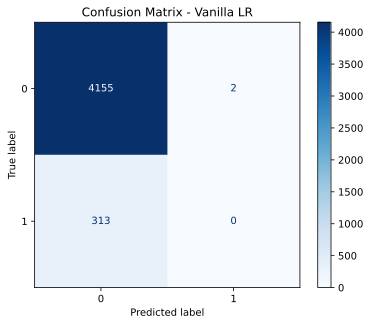

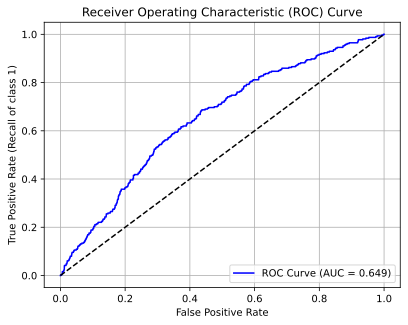

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Vanilla LR")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Readmission (0)", "Readmission (1)"]))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
print(f"AUROC for class 1 (Readmission): {roc_auc:.3f}")

#### Logistic Regression with Upsampling

In [ ]:
kappa = np.sum(y_train) / (np.shape(X_train)[0] - np.sum(y_train))

x_train_upsampled = np.concatenate([X_train, np.tile(X_train[y_train == 1], (int(1 / kappa) - 1, 1))], axis=0)
y_train_upsampled = np.concatenate([y_train, np.tile(y_train[y_train == 1], int(1 / kappa) - 1)], axis=0)

print("Before balancing:", np.bincount(y_train))
print("After balancing:", np.bincount(y_train_upsampled))

x_train_upsampled, y_train_upsampled = shuffle(x_train_upsampled, y_train_upsampled, random_state=42)

Before balancing: [9734  695]
After balancing: [9734 9730]
Accuracy: 0.6539149888143176
AUROC: 0.6420510920799514

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.66      0.78      4157
           1       0.11      0.56      0.19       313

    accuracy                           0.65      4470
   macro avg       0.53      0.61      0.48      4470
weighted avg       0.89      0.65      0.74      4470



In [ ]:
# Normalizing data
scaler = StandardScaler().fit(x_train_upsampled)
x_train_upsampled_normalized = scaler.transform(x_train_upsampled)

model_bal = LogisticRegression(max_iter=100_000)
model_bal.fit(x_train_upsampled_normalized, y_train_upsampled)

X_test_normalized = scaler.transform(X_test)
y_pred_bal = model_bal.predict(X_test_normalized)
y_pred_proba_bal = model_bal.predict_proba(X_test_normalized)[:, 1]

Classification Report (After Upsampling):

                    precision    recall  f1-score   support

No Readmission (0)       0.95      0.67      0.78      4157
   Readmission (1)       0.10      0.51      0.17       313

          accuracy                           0.66      4470
         macro avg       0.53      0.59      0.48      4470
      weighted avg       0.89      0.66      0.74      4470

AUROC after upsampling: 0.636


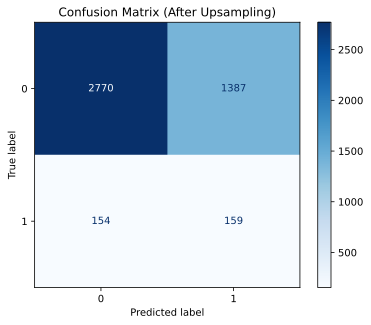

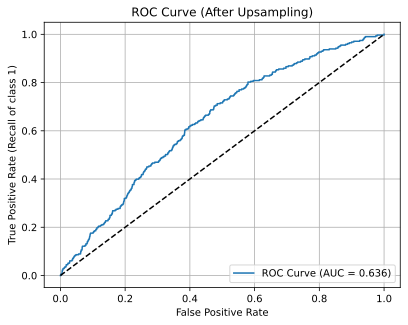

In [ ]:
cm_bal = confusion_matrix(y_test, y_pred_bal)
ConfusionMatrixDisplay(cm_bal).plot(cmap='Blues')
plt.title("Confusion Matrix (After Upsampling)")

print("Classification Report (After Upsampling):\n")
print(classification_report(y_test, y_pred_bal, target_names=["No Readmission (0)", "Readmission (1)"]))

# ROC Curve and AUROC
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_pred_proba_bal, pos_label=1)
roc_auc_bal = auc(fpr_bal, tpr_bal)

plt.figure()
plt.plot(fpr_bal, tpr_bal, label=f'ROC Curve (AUC = {roc_auc_bal:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('ROC Curve (After Upsampling)')
plt.legend(loc='lower right')
plt.grid(True)

print(f"AUROC after upsampling: {roc_auc_bal:.3f}")